# GPX data analysis (single file)

This notebook contains some Python test code to analyze and visualize GPX data from a single file. GPX (GPS Exchange Format) is an XML based file format for GPS tracks, and is widely used by dozens of software programs and web services for GPS data analysis and visualization. 

Data manipulation is done using [gpxpy](https://github.com/tkrajina/gpxpy), a GPX parser for Python, and the [NumPy](http://www.numpy.org/) and [Pandas](https://pandas.pydata.org/) data analysis packages for Python. Visualization is done using:
1. [matplotlib](https://matplotlib.org/)
2. [folium](https://github.com/python-visualization/folium)
3. [mplleaflet](https://github.com/jwass/mplleaflet)

## Prerequisites:

In [1]:
import datetime
import numpy as np
import pandas as pd
import gpxpy

import matplotlib.pyplot as plt
from folium import Map, LatLngPopup, PolyLine, CircleMarker, LayerControl, plugins
import seawater
import mplleaflet

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,gpxpy,matplotlib,seawater,mplleaflet,folium
print("")
%watermark -m

Author: gmalim

last updated: Sat Jul 14 2018

CPython 3.6.5
IPython 6.4.0

numpy 1.14.5
pandas 0.23.3
gpxpy n
matplotlib 2.2.2
seawater 3.3.4
mplleaflet n
folium 0.5.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Load data:

Load single GPX file:

In [2]:
!gpxinfo data/SFMarathon2015.gpx

File: data/SFMarathon2015.gpx
    Length 2D: 44.548km
    Length 3D: 44.696km
    Moving time: 05:25:46
    Stopped time: 00:10:14
    Max speed: 3.00m/s = 10.81km/h
    Total uphill: 760.16m
    Total downhill: 759.16m
    Started: 2015-07-26 12:43:13
    Ended: 2015-07-26 18:19:13
    Points: 20151
    Avg distance between points: 2.21m

    Track #0, Segment #0
        Length 2D: 44.548km
        Length 3D: 44.696km
        Moving time: 05:25:46
        Stopped time: 00:10:14
        Max speed: 3.00m/s = 10.81km/h
        Total uphill: 760.16m
        Total downhill: 759.16m
        Started: 2015-07-26 12:43:13
        Ended: 2015-07-26 18:19:13
        Points: 20151
        Avg distance between points: 2.21m



In [3]:
filename = 'data/SFMarathon2015.gpx'
gpx_file = open(filename, 'r')
gpx = gpxpy.parse(gpx_file)

print("--> File contains {} track(s)".format(len(gpx.tracks)))

track = gpx.tracks[0]

print("--> File contains {} segment(s)".format(len(track.segments)))

segment = track.segments[0]

print("--> File contains {} point(s)".format(len(segment.points)))

track_length   = track.length_3d()    # [m]
track_duration = track.get_duration() # [s]

print("")
print("--> Track name       =", track.name)
print("--> Track start time =", track.get_time_bounds().start_time)
print("--> Track end time   =", track.get_time_bounds().end_time)
print("--> Track length     = {:.3f} km".format(track_length*1e-3))
print("--> Track duration   = {} secs".format(track_duration))
print("--> Track duration   = {} (h:m:s)".format(datetime.timedelta(seconds=track_duration)))
print("--> Track ave speed  = {:.3f} km/hr".format(track_length/track_duration*3.6))
print("--> Track max speed  = {:.3f} km/hr".format(track.get_moving_data().max_speed*3.6))

--> File contains 1 track(s)
--> File contains 1 segment(s)
--> File contains 20151 point(s)

--> Track name       = SF Marathon 2015
--> Track start time = 2015-07-26 12:43:13
--> Track end time   = 2015-07-26 18:19:13
--> Track length     = 44.696 km
--> Track duration   = 20160 secs
--> Track duration   = 5:36:00 (h:m:s)
--> Track ave speed  = 7.981 km/hr
--> Track max speed  = 10.806 km/hr


Create list of GPX points from run data:

In [4]:
gpx_points = []

for point_idx, point in enumerate(segment.points):
            
    gpx_points.append([point.time, 
                       point.latitude, 
                       point.longitude, 
                       point.elevation, 
                       segment.get_speed(point_idx)])

Transform list of GPX points into Pandas dataframe:

In [5]:
column_list = ['Point_Time', 
               'Point_Latitude',
               'Point_Longitude', 
               'Point_Elevation', 
               'Point_Speed']

df = pd.DataFrame(gpx_points, columns=column_list)

print(df.head())

           Point_Time  Point_Latitude  Point_Longitude  Point_Elevation  \
0 2015-07-26 12:43:13       37.793376      -122.391913              1.0   
1 2015-07-26 12:43:14       37.793384      -122.391930              1.0   
2 2015-07-26 12:43:15       37.793391      -122.391957              1.0   
3 2015-07-26 12:43:16       37.793414      -122.391976              1.0   
4 2015-07-26 12:43:17       37.793435      -122.392001              1.0   

   Point_Speed  
0     1.714262  
1     2.102781  
2     2.801284  
3     3.142683  
4     3.500992  


## Visualization:

Create simple map of GPS data using **matplotlib**:

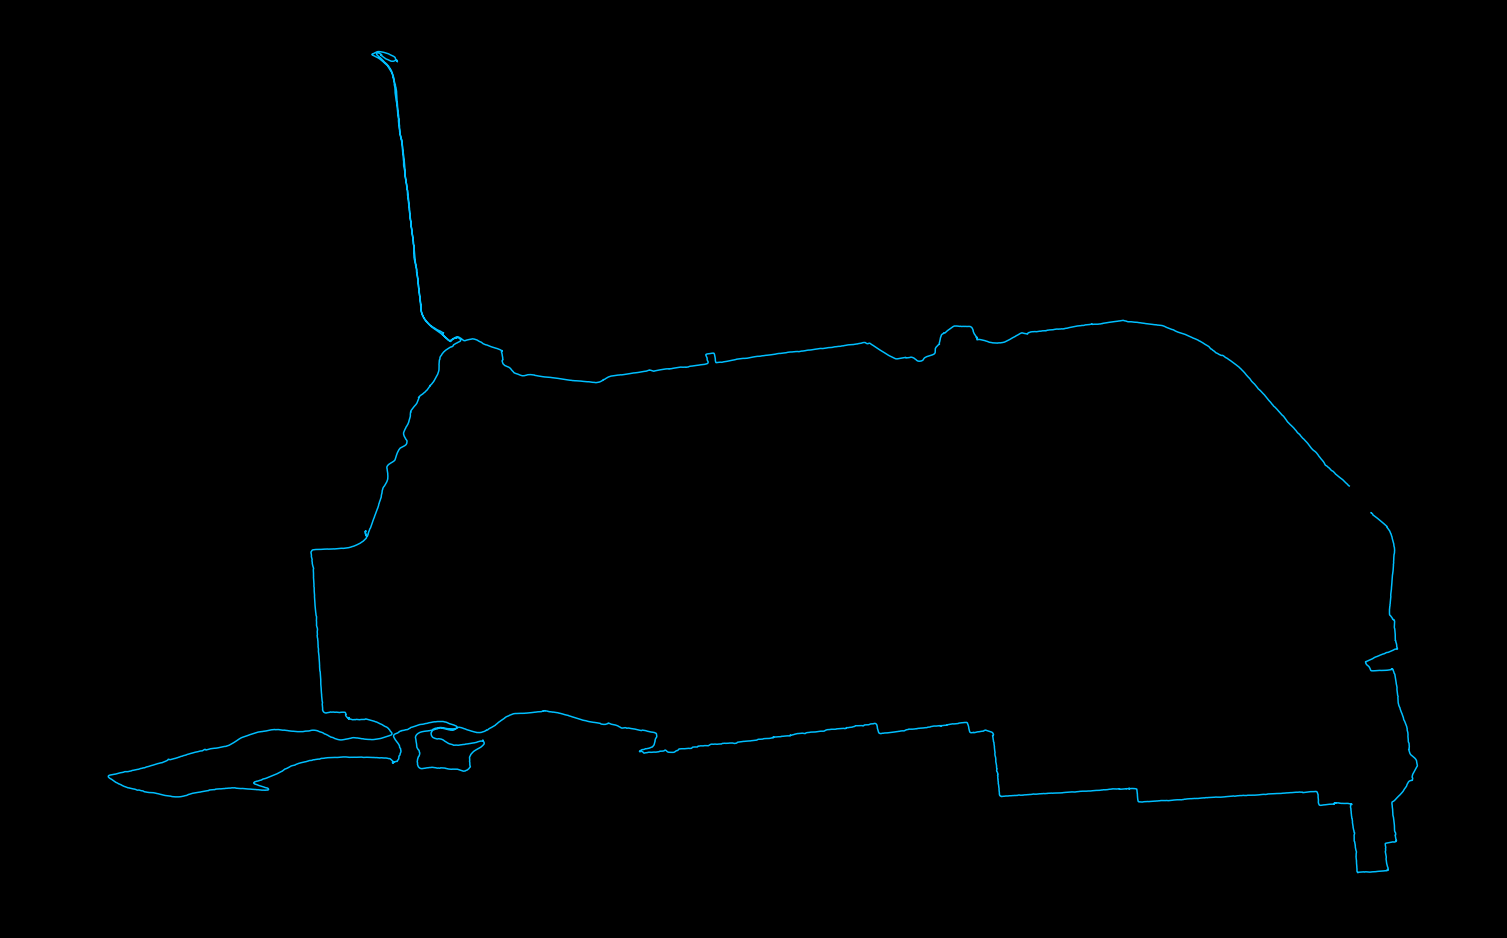

In [6]:
fig = plt.figure(figsize=(20,20), facecolor='black')
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
plt.plot(df['Point_Longitude'], df['Point_Latitude'], color='deepskyblue')
plt.show()

Create [Leaflet.js](https://leafletjs.com/) map of GPS data using **folium**:

In [7]:
# Create basemap:

fmap = Map(location=[df.Point_Latitude.mean()+0.01, df.Point_Longitude.mean()], zoom_start=13, 
           control_scale = True, tiles=None)

# Add tilesets to map:

builtin_tilesets = ['OpenStreetMap', 'CartoDB Positron']

for bts in builtin_tilesets:
    fmap.add_tile_layer(tiles=bts, name=bts)

mapservernames = ['World_Topo_Map', 'World_Imagery']

for msn in mapservernames:
    url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
    service = msn + '/MapServer/tile/{z}/{y}/{x}'
    tileset = url_base + service
    fmap.add_tile_layer(tiles=tileset, name=msn, attr=msn)
    
# Add fullscreen button:

plugins.Fullscreen(
    position='topleft',
    title='Enter fullscreen-mode',
    title_cancel='Exit fullscreen-mode',
    force_separate_button=True).add_to(fmap)

# Add button to enabling/disabling scrolling - DOESN'T WORK?:

# plugins.ScrollZoomToggler().add_to(fmap)

# Add latitude-longitude popup click-tool:

fmap.add_child(LatLngPopup())

# Add track to map:

polylinepoints = []
for lat, lon in zip(df['Point_Latitude'], df['Point_Longitude']):
    polylinepoints.append(tuple([lat,lon]))

PolyLine(locations=polylinepoints, color="blue", weight=5, opacity=0.5).add_to(fmap)

# Add minute-spaced points along track to map:

for i, coord in enumerate(df[['Point_Latitude','Point_Longitude']].values):
    if (i%60 != 0):
        continue
    CircleMarker(location=[coord[0],coord[1]], radius=1, color='red').add_to(fmap)

# Add layer-control button:
    
lc = LayerControl()
fmap.add_child(lc)
    
# Save map:
    
fmap.save('folium_map.html')

In [8]:
%%HTML
<iframe width="100%" height="700" src="folium_map.html"></iframe>

Create [Leaflet.js](https://leafletjs.com/) quiver map of GPS data using **mplleaflet**:

In [9]:
# Calculate angles between GPS points:
_, angles = seawater.dist(df['Point_Latitude'], df['Point_Longitude'])
angles = np.r_[0, np.deg2rad(angles)]

# Normalize arrow lengths using speed:
max_speed = df['Point_Speed'].max()
r = df['Point_Speed'] / max_speed
df['u'] = r * np.cos(angles)
df['v'] = r * np.sin(angles)

fig, ax = plt.subplots()
ax.plot(df['Point_Longitude'], df['Point_Latitude'], color='deepskyblue', linewidth=5, alpha=0.8)

skip = 20
ax.quiver(df['Point_Longitude'][::skip], df['Point_Latitude'][::skip], 
          df['u'][::skip], df['v'][::skip], color='magenta', scale=20)

#mplleaflet.display(fig=fig) 
#mplleaflet.display(fig=fig, tiles='esri_aerial') 
mplleaflet.show(path='mplleaflet_map.html', tiles='esri_aerial')

In [10]:
%%HTML
<iframe width="100%" height="700" src="mplleaflet_map.html"></iframe>